In [1]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import os
import cv2
import math as m
import random
from tqdm import tqdm
from matplotlib import pyplot as plt

### Refine Images

**Try**
1. under_30에서 bbox를 20개 뽑고 resizing
2. under_5이미지에 랜덤으로 삽입
**Expected results**
- bbox가 5개 이하인 이미지들은 상대적으로 배경도 많고 bbox가 크다
- 작은 객체들을 더 잘 detect하기를 기대

In [2]:
basedir = '/opt/ml/detection/dataset/'
data_json = basedir + 'train.json'

In [3]:
#json 불러오기 + Dataframe형태로 변경
with open (data_json, 'r') as outfile:
    data = json.load(outfile)

df_images = pd.DataFrame(data['images'])
df_annotations = pd.DataFrame(data['annotations'])
df_categories = pd.DataFrame(data['categories'])

In [4]:
#df_images, df_annotations merge and generate df
df_images_tmp = df_images.rename(columns={'id':'image_id'})
df = df_images_tmp.merge(df_annotations, how='left', on='image_id')
df.head(2)

,width,height,file_name,license,flickr_url,coco_url,date_captured,image_id,category_id,area,bbox,iscrowd,id
0,1024,1024,train/0000.jpg,0,None,None,2020-12-26 14:44:23,0,0,257301.66,"[197.6, 193.7, 547.8, 469.7]",0,0
1,1024,1024,train/0001.jpg,0,None,None,2021-01-10 16:30:39,1,3,10402.56,"[0.0, 407.4, 57.6, 180.6]",0,1


In [5]:
#1. Count bboxes per image
#2. Get images that counts under 30 bboxes 
df_count = df['image_id'].value_counts().reset_index().rename(columns={'index':'image_id', 'image_id':'counts'})
df_under5 = df_count.loc[df_count['counts'] <= 5]
df_under5.sort_values(by='image_id')

,image_id,counts
4882,0,1
3438,2,1
2806,3,2
3441,6,1
2804,7,2
...,...,...
3440,4878,1
1522,4879,4
3439,4880,1
1524,4881,4


In [6]:
#Get bbox , resize and return
def get_resize_img(i, df):

    xmin, ymin, w, h = df.loc[i, 'bbox']

    xmax = xmin+w
    ymax = ymin+h

    bb_file_name = df.loc[i, 'file_name']

    img = cv2.imread(basedir+bb_file_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    c_img = img[int(ymin):int(ymax),int(xmin):int(xmax)]
    
    resized_img = random_resize_img(c_img)
    
    return resized_img

#random으로 resizing
def random_resize_img(img):

    W, H, _ = img.shape
    '''
    좀 바꿔보자 범위를 나누는게 아닌 img_size를 특정 크기만큼 나눠서 random 생성
    '''
    img_size = H*W
    if 300000 <=  img_size:
        ran_num = random.random()*img_size/10 + 20000
        
    elif 100000 <= img_size and img_size < 300000:
        ran_num = random.random()*img_size/10 + 10000
    
    elif 20000 <= img_size and img_size < 100000:
        ran_num = random.random()*img_size/10 + 5000
        
    elif 5000 <= img_size and img_size < 20000:
        ran_num = random.random()*img_size/5 + 500
        
    else:
        img = cv2.resize(img, dsize=(H, W), interpolation=cv2.INTER_AREA)
        return img
    
    ratio = ran_num/ (H*W)
    CH = int(H*m.sqrt(ratio))
    CW = int(W*m.sqrt(ratio))
    
    img = cv2.resize(img, dsize=(CH, CW), interpolation=cv2.INTER_AREA)

    return img

In [7]:
def get_added_img(img_original, img_id, num):

    img_list = []
    tmp_series_list = []
    
    for _ in range(num):
        ran_idx = np.random.randint(len(df))
        img = get_resize_img(ran_idx, df)
        w, h, _ = img.shape
        img_list.append([img, w, h, ran_idx])
        
    #큰이미지 아래 작은 이미지가 겹치는것을 방비
    img_sorted_list = sorted(img_list, key=lambda l:l[1]*l[2], reverse=True)

    for i in range(num):

        w = img_sorted_list[i][1]
        h = img_sorted_list[i][2]
        idx = img_sorted_list[i][3]
        r_x_point = np.random.randint(1024-w)
        r_y_point = np.random.randint(1024-h)

        img_original[r_x_point:r_x_point+w,r_y_point:r_y_point+h,:] = img_sorted_list[i][0]
        
        ##anno
        tmp_series= df.loc[idx].copy() 
        tmp_series['image_id'] = img_id
        tmp_series['bbox'] = [r_x_point, r_y_point, w, h] 
        tmp_series['area'] = w*h
        tmp_series_list.append(list(tmp_series))
    
    df_new_anno = pd.concat([pd.DataFrame([tmp_series], columns=[df.columns]) for tmp_series in tmp_series_list])

    return img_original, df_new_anno

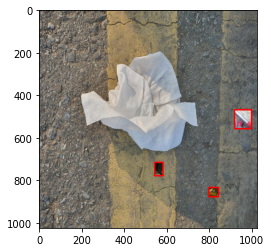

In [8]:
img_o = cv2.imread(basedir + df_images.loc[0, 'file_name'])
img_o = cv2.cvtColor(img_o, cv2.COLOR_BGR2RGB)    
img_id = df_images.loc[0, 'id']

img_or,df_add = get_added_img(img_o.copy(), img_id, 3)

df_add.columns=['width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured', 'image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id']

for bbox in list(df_add['bbox']):
    
    x,y,w,h = bbox
    img_or = cv2.rectangle(img_or, (y,x), (y+h,x+w), (255,0,0), 5)

plt.imshow(img_or)

In [9]:
img_o.shape

(1024, 1024, 3)

In [10]:
df_images['new_file_name'] = df_images['file_name'].str.replace('train', 'new_added_train')
#5개 이하 쳐져있는 image 하나 랜덤으로 뽑기
image_ids = df_under5['image_id'].sort_values().to_frame()
df_im = image_ids.merge(df_images_tmp, how='left', on='image_id')
df_new_anno = pd.DataFrame()

In [ ]:
df_new_anno_list = []
for i in tqdm(range(len(df_images))):
    
    img_original = cv2.imread(basedir + df_images.loc[i, 'file_name'])
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)    
    img_id = df_images.loc[i, 'id']
    
    if img_id in list(df_im['image_id']):
        #랜덤 num개 bbox 삽입
        img_original,df_add = get_added_img(img_original, img_id, 25)
        df_new_anno_list.append(df_add)
    plt.imsave(basedir + df_images.loc[i, 'new_file_name'], img_original)


 67%|██████▋   | 3277/4883 [21:06<07:39,  3.49it/s]

In [ ]:
df_new_anno = pd.concat([df_new_anno for df_new_anno in df_new_anno_list])

In [ ]:
df_new_anno = df_new_anno.reset_index().iloc[:, 8:]

In [ ]:
df_new_anno.columns = ['image_id', 'category_id', 'area', 'bbox', 'iscrowd', 'id']

In [ ]:
df_anno_final = pd.concat([df_annotations, df_new_anno], ignore_index=True)
df_anno_final = df_anno_final.sort_values(by='image_id').reset_index()
df_anno_final = df_anno_final.drop('index', axis=1).drop('area', axis=1)
df_anno_final['id'] = np.arange(len(df_anno_final))

area_list = []
for bbox in df_anno_final['bbox']:

    area_list.append(bbox[2]*bbox[3])

df_anno_final['area'] = area_list
df_anno_final.head(2)

In [ ]:
# 수정된 json 저장
df_new_images = df_images.drop('file_name', axis=1)
df_new_images = df_new_images.rename(columns={'new_file_name':'file_name'})

In [ ]:
new_images_json = df_new_images.to_json(orient = 'records')
new_images_json = json.loads(new_images_json)

new_anno_json = df_anno_final.to_json(orient = 'records')
new_anno_json = json.loads(new_anno_json)

new_json = json.dumps({'images':new_images_json, 'annotations':new_anno_json, 'categories':data['categories']})
parsed_json = json.loads(new_json)

file_path = '/opt/ml/detection/dataset/new_cutmix.json'

with open(file_path, 'w') as outfile:
    json.dump(parsed_json, outfile, indent=4)